In [1]:
import pandas as pd
import numpy as np
import sklearn

import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.linear_model import LinearRegression
from sklearn import metrics

#Data preprocessing

In [2]:
flight_delay_df = pd.read_csv('flight_delay.csv')

In [3]:
flight_delay_df.describe()
errors = {}

The maximum value of Delay is 1436 min, mean is 10 min. It shows, that very big delays are outliers.

In [4]:
flight_delay_df["Scheduled depature time"] = pd.to_datetime(flight_delay_df["Scheduled depature time"])
flight_delay_df["Scheduled arrival time"] = pd.to_datetime(flight_delay_df["Scheduled arrival time"])

The format of "Scheduled departure time" and "Scheduled arrival time" are changed from string to datetime

In [5]:
flight_delay_df["Duration of flight"] = flight_delay_df["Scheduled arrival time"] - flight_delay_df["Scheduled depature time"]
flight_delay_df["Duration of flight"] = flight_delay_df["Duration of flight"].dt.total_seconds()/60



Duration of rhe flight is calculated and added to the current data frame. 

In [6]:
flight_delay_df["Year of departure"] = flight_delay_df["Scheduled depature time"].dt.strftime("%Y")
flight_delay_df["Month of departure"] = flight_delay_df["Scheduled depature time"].dt.strftime("%m")
flight_delay_df["Day of departure"] = flight_delay_df["Scheduled depature time"].dt.strftime("%d")
flight_delay_df["Day of the week of departure"] = flight_delay_df["Scheduled depature time"].dt.strftime("%a")
flight_delay_df["Hour of departure"] = flight_delay_df["Scheduled depature time"].dt.hour
flight_delay_df["Minute of departure"] = flight_delay_df["Scheduled depature time"].dt.minute

flight_delay_df["Year of arrival"] = flight_delay_df["Scheduled arrival time"].dt.strftime("%Y")
flight_delay_df["Month of arrival"] = flight_delay_df["Scheduled arrival time"].dt.strftime("%m")
flight_delay_df["Day of arrival"] = flight_delay_df["Scheduled arrival time"].dt.strftime("%d")
flight_delay_df["Day of the week of arrival"] = flight_delay_df["Scheduled arrival time"].dt.strftime("%a")
flight_delay_df["Hour of arrival"] = flight_delay_df["Scheduled arrival time"].dt.hour
flight_delay_df["Minute of arrival"] = flight_delay_df["Scheduled arrival time"].dt.minute





Now, we extract features from date: Month, Year, Day tc

In [7]:
del flight_delay_df["Scheduled depature time"]

In [8]:
del flight_delay_df["Scheduled arrival time"]

Useless columns are deleted, because this information is presented in new features from previous step

In [9]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
flight_delay_df["Depature Airport"] = le.fit_transform(flight_delay_df["Depature Airport"])
flight_delay_df["Destination Airport"] = le.fit_transform(flight_delay_df["Destination Airport"])
flight_delay_df["Day of the week of departure"] = le.fit_transform(flight_delay_df["Day of the week of departure"])
flight_delay_df["Day of the week of arrival"] = le.fit_transform(flight_delay_df["Day of the week of arrival"])



All categorical features are encoded with Labelencoder. Later, we will show, that they have small weights.


In [10]:
y = flight_delay_df["Delay"]
X = flight_delay_df.drop("Delay", axis = 1)

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
x_PCA = pca.fit_transform(X)

print(pca.mean_)
print(pca.components_)
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[ 115.16711299  115.34194901  196.03535091 2016.82823277    6.38981929
   15.81306207    2.99280251   12.06809047   27.18190027 2016.8282979
    6.39266306   15.81870223    2.99412891   12.55703739   26.99713403]
[[-1.42867335e-02 -2.08484602e-02  9.99649745e-01 -9.22280582e-05
   1.14055841e-05 -8.11938265e-05 -9.74960679e-05 -2.82505337e-03
  -4.49707464e-04 -9.10610013e-05  2.46731290e-05 -5.07752553e-05
  -5.24172207e-05 -6.76785190e-03 -2.75546008e-03]]
[14857.77873493]
[0.74605151]


We need to choose feature to visualise data. So we use PCA with 1 component

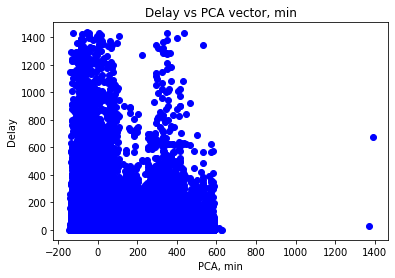

In [12]:
plt.plot(x_PCA, y,'bo')
plt.title('Delay vs PCA vector, min')
plt.xlabel('PCA, min')
plt.ylabel('Delay')
plt.show()

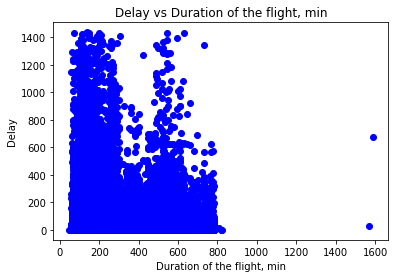

In [13]:
plt.plot(X['Duration of flight'],y,'bo')
plt.title('Delay vs Duration of the flight, min')
plt.xlabel('Duration of the flight, min')
plt.ylabel('Delay')
plt.show()

We can see that PCA give us Duration vector as most important for research. We will use it in the models that requires only one feature.

#Removing outliers

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


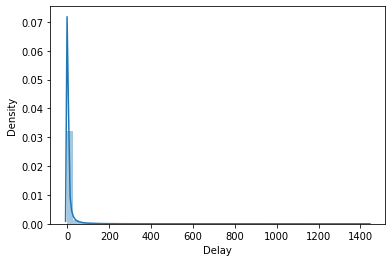

In [14]:
import seaborn as sns
sns_plot = sns.distplot(y)
fig = sns_plot.get_figure()

Here is the histogram of Delay. It's clear that the most of delay values are concentrated in the the interval from 0 to 100 minutes. In the future we will remove outliers using Isolation Forest.

In [15]:
flight_delay_df["Year of departure"] = flight_delay_df["Year of departure"].astype(int)
flight_delay_df["Month of departure"] = flight_delay_df["Month of departure"].astype(int)
flight_delay_df["Day of departure"] = flight_delay_df["Day of departure"].astype(int)
flight_delay_df["Hour of departure"] = flight_delay_df["Hour of departure"].astype(int)
flight_delay_df["Minute of departure"] = flight_delay_df["Minute of departure"].astype(int)

flight_delay_df["Year of arrival"] = flight_delay_df["Year of arrival"].astype(int)
flight_delay_df["Month of arrival"] = flight_delay_df["Month of arrival"].astype(int)
flight_delay_df["Day of arrival"] = flight_delay_df["Day of arrival"].astype(int)
flight_delay_df["Hour of arrival"] = flight_delay_df["Hour of arrival"].astype(int)
flight_delay_df["Minute of arrival"] = flight_delay_df["Minute of arrival"].astype(int)



The features tuoes are changed from string to integer.

In [16]:

X_train = flight_delay_df[(flight_delay_df["Year of departure"] < 2018)]
X_train = X_train.drop("Delay", axis = 1)
y_train = flight_delay_df[(flight_delay_df["Year of departure"] < 2018)]
y_train = y_train["Delay"]
X_test = flight_delay_df[(flight_delay_df["Year of departure"] == 2018)]
X_test = X_test.drop("Delay", axis = 1)
y_test = flight_delay_df[(flight_delay_df["Year of departure"] == 2018)]
y_test = y_test["Delay"]

Data is splitted into train and set. The train data is all the data from year 2015 till 2017. All the data samples collected in year 2018
are to be used as testing set

In [17]:
from sklearn.ensemble import IsolationForest
y_train_array = np.asarray(y_train)
y_train_array = y_train_array.reshape(-1,1)
clf = IsolationForest(contamination = 0.05)
clf.fit(y_train_array)
preds = clf.predict(y_train_array)



In [18]:
y_outliers = list(preds)


In [19]:
new_df = flight_delay_df[(flight_delay_df["Year of departure"] < 2018)]
new_df["Indicator"] = y_outliers
new_df = new_df[new_df["Indicator"]!=-1]
X_train = new_df.drop("Delay",axis = 1)
X_train = X_train.drop("Indicator",axis = 1)
y_train = new_df["Delay"]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In this step we detected outliers and remove them from train set. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


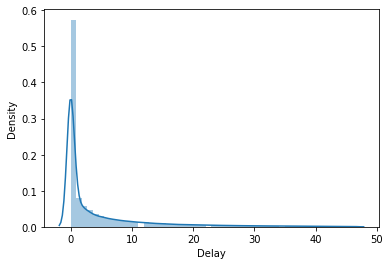

In [20]:
import seaborn as sns
sns_plot = sns.distplot(y_train)
fig = sns_plot.get_figure()

We dropped all points which delay is greater than 50 minutes.

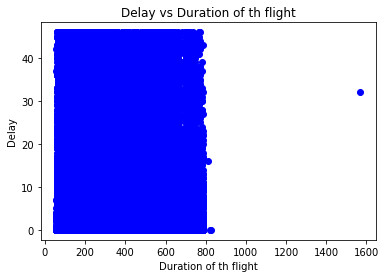

In [21]:
plt.plot(X_train["Duration of flight"], y_train,'bo')
plt.title('Delay vs Duration of th flight')
plt.xlabel('Duration of th flight')
plt.ylabel('Delay')
plt.show()

In [22]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)
print(f"Model intercept : {regressor.intercept_}")
print(f"Model coefficient : {regressor.coef_}")
print(X_train.shape)
print(X_test.shape)
y_pred = regressor.predict(X_test)
eval_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}) ### что это


Model intercept : -706.852138220332
Model coefficient : [-6.14814713e-03  6.96223733e-03  1.05324705e-02  3.58970210e+01
  2.55666680e+00  1.05472912e-01 -5.96890003e-02  8.94366545e-02
  5.65463398e-03 -3.55462251e+01 -2.47912031e+00 -1.04536263e-01
 -1.94949212e-02  2.11566085e-02  1.72402223e-03]
(474571, 15)
(176451, 15)


#Models

In [24]:
print(y.mean())
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Coefficient of determination R^2',metrics.r2_score(y_test, y_pred))
errors_list = [metrics.mean_absolute_error(y_test, y_pred),metrics.mean_squared_error(y_test, y_pred),np.sqrt(metrics.mean_squared_error(y_test, y_pred)),metrics.r2_score(y_test, y_pred)]
errors["Linear regresion"] = errors_list

9.912938759135649
Mean Absolute Error: 9.576556143406462
Mean Squared Error: 1601.7574288334881
Root Mean Squared Error: 40.02196183139313
Coefficient of determination R^2 0.0006327839831499205


We use Linear Regression for predictions. The error is big. And determination coefficient is small. In normal model it should be grater than 50%.

In [25]:
from sklearn import linear_model
model = linear_model.Lasso()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(y.mean())
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Coefficient of determination R^2',metrics.r2_score(y_test, y_pred))
errors_list = [metrics.mean_absolute_error(y_test, y_pred),metrics.mean_squared_error(y_test, y_pred),np.sqrt(metrics.mean_squared_error(y_test, y_pred)),metrics.r2_score(y_test, y_pred)]
errors["Linear regresion with Lasso"] = errors_list

9.912938759135649
Mean Absolute Error: 9.280717413855568
Mean Squared Error: 1601.8926055635097
Root Mean Squared Error: 40.02365057767107
Coefficient of determination R^2 0.0005484446256913689


In [26]:
X_test.shape
X_train_1D = X_train["Duration of flight"]
X_train_1D = np.array(X_train_1D)
X_train_1D = X_train_1D.reshape(-1,1)
X_test_1D = X_test["Duration of flight"]
X_test_1D = np.array(X_test_1D)
X_test_1D = X_test_1D.reshape(-1,1)

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
degrees = [2,4,5]
for i in degrees:
  poly_features= PolynomialFeatures(degree=i)
  x_train_poly = poly_features.fit_transform(X_train_1D)
  poly_model = LinearRegression()
  poly_model.fit(x_train_poly, y_train)

  # predicting on training data-set
  y_train_predicted = poly_model.predict(x_train_poly)

  # predicting on test data-set
  y_test_predict = poly_model.predict(poly_features.fit_transform(X_test_1D))

  # evaluating the model on training dataset
  print("Degree = ", i)
  print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_train_predicted))
  print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_train_predicted))
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_train_predicted)))
  print('Coefficient of determination R^2',metrics.r2_score(y_train, y_train_predicted))

  # evaluating the model on test dataset
  print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_test_predict))
  print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_test_predict))
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_predict)))
  print('Coefficient of determination R^2',metrics.r2_score(y_test, y_test_predict))
  errors_list = [metrics.mean_absolute_error(y_test, y_pred),metrics.mean_squared_error(y_test, y_pred),np.sqrt(metrics.mean_squared_error(y_test, y_pred)),metrics.r2_score(y_test, y_pred)]
  errors["Polynomial regresion"+str(i)] = errors_list


Degree =  2
Mean Absolute Error: 5.587441522681744
Mean Squared Error: 68.11284439934033
Root Mean Squared Error: 8.25305061170355
Coefficient of determination R^2 0.021143928037761772
Mean Absolute Error: 9.31215573520325
Mean Squared Error: 1602.9788739232552
Root Mean Squared Error: 40.03721860873024
Coefficient of determination R^2 -0.00012929906195080498
Degree =  4
Mean Absolute Error: 5.5856975830454445
Mean Squared Error: 68.08246253132513
Root Mean Squared Error: 8.251209761684958
Coefficient of determination R^2 0.021580548711094383
Mean Absolute Error: 9.309813613417848
Mean Squared Error: 1602.728618266429
Root Mean Squared Error: 40.03409319900263
Coefficient of determination R^2 2.6840247630444125e-05
Degree =  5
Mean Absolute Error: 5.584960829461017
Mean Squared Error: 68.07260238527859
Root Mean Squared Error: 8.25061224305679
Coefficient of determination R^2 0.021722249794248527
Mean Absolute Error: 9.311124455840757
Mean Squared Error: 1602.6819023267742
Root Mean Sq

The same cocnlusion about Polynomial regression and Linear regresiion with Lasso regularization. Perhaps It's connected with abnormal points. In the traing set we exclude points with delays greater than 50, while in test we have points with delays greater than 1000. So this points give enourmous error. 

#Detecting novelties

In [28]:
preds_test = clf.predict(y_test.values.reshape(-1,1))

Now we try to detect novelties. And see what happen.

from sklearn.svm import SVR
lw = 2
X_train_1D = X_train["Duration of flight"]
X_train_1D = np.array(X_train_1D)
X_train_1D = X_train_1D.reshape(-1,1)
X_test_1D = X_test["Duration of flight"]
X_test_1D = np.array(X_test_1D)
X_test_1D = X_test_1D.reshape(-1,1)
svr = SVR(kernel='linear', C=100, gamma='auto')
plt.plot(X_train, svr.fit(X_train_1D, y_train).predict(X_train_1D), color='c', lw=lw,
                  label='{} model'.format('Linear'))
plt.show()

In [29]:
new_df_test = flight_delay_df[(flight_delay_df["Year of departure"] == 2018)]
new_df_test["Index"] = preds_test
new_df_test = new_df_test[new_df_test["Index"]!=-1]
X_test_new = new_df_test.drop("Delay",axis = 1)
X_test_new = X_test_new.drop("Index",axis = 1)
y_test_new = new_df_test["Delay"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [30]:
y_pred = regressor.predict(X_test_new)
eval_df = pd.DataFrame({'Actual': y_test_new, 'Predicted': y_pred}) ### что это
print(y.mean())
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_new, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test_new, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_new, y_pred)))
print('Coefficient of determination R^2',metrics.r2_score(y_test_new, y_pred))

9.912938759135649
Mean Absolute Error: 5.3342125245990415
Mean Squared Error: 46.28470039745933
Root Mean Squared Error: 6.803285999975257
Coefficient of determination R^2 -0.21658770291257556


In [31]:
y_pred = model.predict(X_test_new)
eval_df = pd.DataFrame({'Actual': y_test_new, 'Predicted': y_pred}) ### что это
print(y.mean())
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_new, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test_new, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_new, y_pred)))
print('Coefficient of determination R^2',metrics.r2_score(y_test_new, y_pred))

9.912938759135649
Mean Absolute Error: 5.019925638653846
Mean Squared Error: 43.70571823640101
Root Mean Squared Error: 6.611030043525821
Coefficient of determination R^2 -0.14879947146176375


In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
degrees = [2,4,5]
X_test_1D = X_test_new["Duration of flight"].values.reshape(-1,1)
for i in degrees:
  poly_features= PolynomialFeatures(degree=i)
  x_train_poly = poly_features.fit_transform(X_train_1D)
  poly_model = LinearRegression()
  poly_model.fit(x_train_poly, y_train)

  # predicting on training data-set
  y_train_predicted = poly_model.predict(x_train_poly)

  # predicting on test data-set
  y_test_predict = poly_model.predict(poly_features.fit_transform(X_test_1D))

  # evaluating the model on training dataset
  print("Degree = ", i)
  print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_train_predicted))
  print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_train_predicted))
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_train_predicted)))
  print('Coefficient of determination R^2',metrics.r2_score(y_train, y_train_predicted))

  # evaluating the model on test dataset
  print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_new, y_test_predict))
  print('Mean Squared Error:', metrics.mean_squared_error(y_test_new, y_test_predict))
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_new, y_test_predict)))
  print('Coefficient of determination R^2',metrics.r2_score(y_test_new, y_test_predict))

Degree =  2
Mean Absolute Error: 5.587441522681744
Mean Squared Error: 68.11284439934033
Root Mean Squared Error: 8.25305061170355
Coefficient of determination R^2 0.021143928037761772
Mean Absolute Error: 5.049195843042351
Mean Squared Error: 43.91476474332208
Root Mean Squared Error: 6.626821616983672
Coefficient of determination R^2 -0.15429423339115012
Degree =  4
Mean Absolute Error: 5.5856975830454445
Mean Squared Error: 68.08246253132513
Root Mean Squared Error: 8.251209761684958
Coefficient of determination R^2 0.021580548711094383
Mean Absolute Error: 5.047380538152637
Mean Squared Error: 43.903117678571014
Root Mean Squared Error: 6.625942776584402
Coefficient of determination R^2 -0.1539880917151859
Degree =  5
Mean Absolute Error: 5.584960829461017
Mean Squared Error: 68.07260238527859
Root Mean Squared Error: 8.25061224305679
Coefficient of determination R^2 0.021722249794248527
Mean Absolute Error: 5.048951127118257
Mean Squared Error: 43.916685859531306
Root Mean Squared

The error is decreased.